In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch_geometric as tg
%matplotlib inline


In [2]:
# open the molecule data
df = pd.read_csv("C:/Users/sagar/Documents/molecular_data.csv")
df.head()

,Number of Atoms,CSD_Label,Atom,X,Y,Z
0,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,Ir,5.830300,3.029099,16.717265
1,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,O,4.591596,4.113017,15.213939
2,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,O,4.102707,3.441509,18.051009
3,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,N,6.651509,4.646264,17.527821
4,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,N,5.003926,1.431850,15.851927


In [10]:
# open SMILES data
smiles = pd.read_csv("C:/Users/sagar/Documents/input_smiles.csv")
smiles.head()

,atoms,SMILES,CSD_code,q,S,Stoichiometry,MND
0,116,[La]1(N(c2c(cccc2C(C)C)C(C)C)[C](N1c1c(cccc1C(...,WIXKOE,0,0,C47H65LaN2O,7
1,42,[Sc]123(ON(O1)[O])(ON([O])O2)ON([O])O3.n1ccccc...,DUCVIG,0,0,C13H10N9O9Sc,8
2,73,[La]123(O[C](C=C(O1)C(F)(F)F)C(F)(F)F)(OC(=C[C...,KINJOG,0,0,C23H21F18LaO10,10
3,46,[Sc]123(OC(=C[C](O1)C(F)(F)F)C(F)(F)F)(O[C](C(...,GEKYEC,0,0,C15H5F18O7Sc,7
4,72,n1([Y][C@@]2([C](C(=C([C]2C)C)C)C)C)c(c(c(c1C)...,PIBNEV,0,0,C28H42NY,11


In [11]:
# Open property data
prop = pd.read_csv("C:/Users/sagar/Documents/new_quality.csv")

In [3]:
# import packages

# general tools
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

In [4]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [5]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [6]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [7]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = get_atom_features(atom)
                
            X = torch.tensor(X, dtype = torch.float)
            
            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)
            
            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))
            
            for (k, (i,j)) in enumerate(zip(rows, cols)):
                
                EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
            
            EF = torch.tensor(EF, dtype = torch.float)
            
            # construct label tensor
            y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
            
            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [8]:
# Check if SMILES string is valid in entire dataset and filter out invalid SMILES Strings and associated labels from quality

def check_smiles_validity(smiles):
    """
    Takes a SMILES string as input and returns True if the SMILES string is valid and False otherwise.
    """
    try:
        Chem.MolFromSmiles(smiles)
        return True
    except:
        return False

# check if SMILES string is valid in entire dataset and filter out invalid SMILES Strings 

smiles['Valid'] = smiles['SMILES'].apply(lambda x: check_smiles_validity(x))

NameError: name 'smiles' is not defined

In [10]:
prop['SMILES'] = smiles['SMILES']
prop.head()

prop_valid = prop['SMILES'].apply(check_smiles_validity)

In [12]:
# canonical training loop for a Pytorch Geometric GNN model gnn_model

# create list of molecular graph objects from list of SMILES x_smiles and list of labels y
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles['SMILES'].tolist(), prop['LUMO_Energy'].tolist())

[10:46:08] Explicit valence for atom # 20 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 3 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 24 B, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 0 B, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 22 B, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 6 B, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 8 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 8 N, 4, is greater than permitted
[10:46:08] Explicit valence for atom # 30 N, 4,

'\n# create dataloader for training\ndataloader = DataLoader(dataset = data_list, batch_size = 2**7)\n\n# define loss function\nloss_function = nn.MSELoss()\n\n# define optimiser\noptimiser = torch.optim.Adam(gnn_model.parameters(), lr = 1e-3)\n\n# loop over 10 training epochs\nfor epoch in range(10):\n\n    # set model to training mode\n    gnn_model.train()\n\n    # loop over minibatches for training\n    for (k, batch) in enumerate(dataloader):\n\n        # compute current value of loss function via forward pass\n        output = gnn_model(batch)\n        loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))\n\n        # set past gradient to zero\n        optimiser.zero_grad()\n\n        # compute current gradient via backward pass\n        loss_function_value.backward()\n\n        # update model weights using gradient and optimisation method\n        optimiser.step()\n'

In [13]:
len(data_list)

70263

In [14]:
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
train_set, valid_set, test_set = random_split(
    data_list,[40000, 20000, 10263])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

c:\Users\sagar\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
# Build graph neural network using pytocrch geometric on graph data

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(79, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, 8)
        self.fc1 = Linear(8, 4)
        self.fc2 = Linear(4, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [20]:

gnn_model = GNN()
gnn_model

GNN(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 8)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:

# define loss function
loss_function = nn.MSELoss()

# define optimiser
optimiser = torch.optim.Adam(gnn_model.parameters(), lr = 1e-3)

# loop over 10 training epochs
for epoch in range(10):
    
        # set model to training mode
        gnn_model.train()
    
        # loop over minibatches for training
        for (k, batch) in enumerate(trainloader):
    
            # compute current value of loss function via forward pass
            output = gnn_model(batch)
            loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))
    
            # set past gradient to zero
            optimiser.zero_grad()
    
            # compute current gradient via backward pass
            loss_function_value.backward()
    
            # update model weights using gradient and optimisation method
            optimiser.step()

        # Print training loss
        print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss_function_value))

C:\Users\sagar\AppData\Local\Temp\ipykernel_5268\746464174.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))


Epoch: 000, Loss: 0.00302
Epoch: 001, Loss: 0.00281
Epoch: 002, Loss: 0.00358
Epoch: 003, Loss: 0.00301
Epoch: 004, Loss: 0.00182
Epoch: 005, Loss: 0.00222
Epoch: 006, Loss: 0.00292
Epoch: 007, Loss: 0.00139
Epoch: 008, Loss: 0.00171
Epoch: 009, Loss: 0.00226


In [27]:
# Evaluate model on test set

def evaluate(model, loader):
    model.eval()
    error = 0
    for data in loader:
        pred = model(data)
        error += loss_function(pred, data.y).item()
        print (data.y)
        print (pred)
    return error / len(loader.dataset)

print('Test Error: {:.4f}'.format(evaluate(gnn_model, testloader)))

c:\Users\sagar\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([-0.0328, -0.1738, -0.0258, -0.0631, -0.1235, -0.1954, -0.1126, -0.0039,
        -0.0898,  0.0214, -0.1859, -0.0794, -0.0959, -0.0770, -0.0950, -0.0971,
        -0.0522, -0.0562, -0.1933, -0.1798, -0.0861, -0.1740, -0.0945, -0.0751,
        -0.1089, -0.0942, -0.0773, -0.1749, -0.0477, -0.0996, -0.0739, -0.1666])
tensor([[-0.0781],
        [-0.0970],
        [-0.0781],
        [-0.1173],
        [-0.0968],
        [-0.0924],
        [-0.0781],
        [-0.0821],
        [-0.0903],
        [-0.0781],
        [-0.1694],
        [-0.0781],
        [-0.1035],
        [-0.0781],
        [-0.0813],
        [-0.0781],
        [-0.0781],
        [-0.0781],
        [-0.1262],
        [-0.1580],
        [-0.1242],
        [-0.1024],
        [-0.1143],
        [-0.0877],
        [-0.0781],
        [-0.1093],
        [-0.1048],
        [-0.1076],
        [-0.0781],
        [-0.0887],
        [-0.0781],
        [-0.1023]], grad_fn=<AddmmBackward0>)
tensor([-0.0286, -0.1726, -0.0688, -0.1009, 

c:\Users\sagar\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


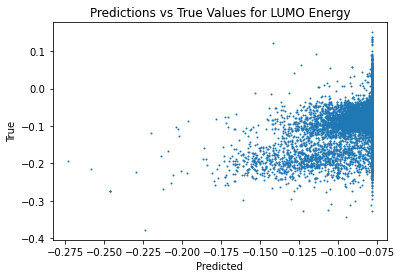

In [56]:
# Plot predictions against true values

import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    for i,data in enumerate(loader):
        pred = model(data)
        y_pred.append(pred.detach().numpy())
        y_true.append(data.y.detach().numpy())
    y_pred = list(np.array(y_pred,dtype=object).flatten())
    y_true = list(np.array(y_true,dtype=object).flatten())
    
    # Concatenate list of numpy arrays across axis 0
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    # Plot predictions against true values
    plt.scatter(y_pred, y_true, s=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Predictions vs True Values for LUMO Energy')
plot_predictions(gnn_model, testloader)